In this experiment, I train the models with noisy data and test the performance on test data.<br>
- If the performace of test dataset is comparable with the performance trained on noise free dataset then the data augmentation is helpful

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '../')

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.base import clone
from sklearn.metrics import r2_score

from pickle import load, dump

from src.load_dataset import load_dataset, select_normalizer
from src.utils import normalizer_inference_dataset, tsen_pca_viz, verify_batch_label_dist, calculate_r2_score, calculate_per_diff, per_error, find_adj_score, combine_all_batches, split_batches_back, perform_combat_normalization
from src.load_models import select_model
from src.graph_visualization import visualization_testing_dataset, visualization_class_stratified
from src.config import *

from src.utils import evaluate_score_class_stratified

from pyod.models.iforest import IForest
from pyod.models.lof import LOF

from pycombat import Combat

In [2]:
def select_outlier_removal(o_removal = 'iforest'):
    if o_removal=='iforest': return IForest(contamination=0.03,n_estimators=100,
                                                 random_state=0) 
    elif o_removal=='lof':   return LOF(contamination=0.03, n_neighbors=5) 

def remove_outlier_box_plot():
    pass
    
    
def find_outliers_in_data(all_combined, labels, outlier_removal_algo, outlier_threshold=0.7):
    ouliers_name = []

    for label in labels:
        
        data  = all_combined[all_combined['y']==label].copy()
        tx    = data.drop(columns=['file', 'y'])

        if outlier_removal_algo != 'IQR':
            o_removal = select_outlier_removal(outlier_removal_algo)
            o_removal.fit(tx)
            predicted = pd.Series(o_removal.predict(tx),index=tx.index)
            
            outliers = predicted[predicted > outlier_threshold] 
            outliers = data.loc[outliers.index] 
            ouliers_name += outliers['file'].map(lambda x: x.split('/')[-1].replace('.txt', '')).to_list()
        else:
            pass
            

    return ouliers_name
    
def normalize_create_training_data(train, test, blank_norm=False, remove_outlier=None, normalizer_type='mean_std'):

    # Remove outlier only from the training dataset
    if remove_outlier=='all':
        
        train = train[train['file'].apply(lambda x: False if (x.split('/')[-1].replace('.txt', '') in ouliners_to_remove) else True)]
        test  = test[test['file'].apply(lambda x: False if (x.split('/')[-1].replace('.txt', '') in ouliners_to_remove) else True)]

    elif remove_outlier=='train_only':
        train = train[train['file'].apply(lambda x: False if (x.split('/')[-1].replace('.txt', '') in ouliners_to_remove) else True)]
        
    train = train.reset_index(drop=True)
    test  = test.reset_index(drop=True)
    
    X_train = train.drop(columns=['file']).copy()
    X_test  = test.drop(columns=['file']).copy()

    columns       = X_train.columns
    
    y_train = train['file'].apply(lambda x: int(x.split('_')[-2].replace('cbz','')))
    y_test  = test['file'].apply(lambda x: int(x.split('_')[-2].replace('cbz','')))

    assert (X_train.index.values == y_train.index.values).all()

    if normalizer_type!=None:
        scaler  = select_normalizer(normalizer_type)
    
        if blank_norm: scaler.fit(X_train[y_train==0])
        else: scaler.fit(X_train)
    
        
        X_train = pd.DataFrame(scaler.transform(X_train), columns=columns)
        X_test  = pd.DataFrame(scaler.transform(X_test),  columns=columns)

    else:
        scaler = None

    X_train.rename(columns={"PH": 'univariate, max(S)', 'signal_std':'univariate, std(S)', 'signal_mean':'univariate, mean(S)', 'peak area':'univariate, area(S)', \
                        'dS_dV_area':'univariate, area(dS/dV)', 'dS_dV_max_peak':'univariate, max(dS/dV)', 'dS_dV_min_peak':'univariate, min(dS/dV)',\
                    'dS_dV_peak_diff':'univariate, max(dS/dV) - min(dS/dV)', \
                    'peak V':'univariate, V_max(S)', 'dS_dV_max_V':'univariate, V_max(dS/dV)', 'dS_dV_min_V':'univariate, V_min(dS/dV)',\
        }, inplace = True)

    X_test.rename(columns={"PH": 'univariate, max(S)', 'signal_std':'univariate, std(S)', 'signal_mean':'univariate, mean(S)', 'peak area':'univariate, area(S)', \
                        'dS_dV_area':'univariate, area(dS/dV)', 'dS_dV_max_peak':'univariate, max(dS/dV)', 'dS_dV_min_peak':'univariate, min(dS/dV)',\
                    'dS_dV_peak_diff':'univariate, max(dS/dV) - min(dS/dV)', \
                    'peak V':'univariate, V_max(S)', 'dS_dV_max_V':'univariate, V_max(dS/dV)', 'dS_dV_min_V':'univariate, V_min(dS/dV)',\
        }, inplace = True)

   

    return (X_train, X_test, y_train, y_test), scaler

def load_dataset_train_test_splitted(filename, load_dataset_name=['ML1', 'ML2', 'ML4']):
    dataset = {}

    if 'ML1' in load_dataset_name:
        dataset['ML1'] = pd.read_excel(f'/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1/{filename}.xlsx')

    if 'ML2' in load_dataset_name:
         dataset['ML2'] = pd.read_excel(f'/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2/{filename}.xlsx')
    
    if 'ML4' in load_dataset_name:
        dataset['ML4'] = pd.read_excel(f'/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4/{filename}.xlsx')

    return dataset



In [3]:
# ouliners_to_remove = ['2024_03_08_cbz16_36', '2024_03_08_cbz16_15']
root_min = True
vwidth   = 0.15
f"feature_extraction_vwidth_{vwidth}_{'root_min_' if root_min else ''}training_noisy"

'feature_extraction_vwidth_0.15_root_min_training_noisy'

In [4]:
vwidth      = 0.15
all_dataset = True
root_min    = True

if all_dataset:
    ML1_noisy_train, ML2_noisy_train, ML4_noisy_train = list(load_dataset_train_test_splitted(f"feature_extraction_vwidth_{vwidth}_{'root_min_' if root_min else ''}training_noisy").values())
    ML1_train, ML2_train, ML4_train = list(load_dataset_train_test_splitted(f"feature_extraction_vwidth_{vwidth}_{'root_min_' if root_min else ''}training").values())
    ML1_test, ML2_test, ML4_test    = list(load_dataset_train_test_splitted(f"feature_extraction_vwidth_{vwidth}_{'root_min_' if root_min else ''}testing").values())

    # Test if training and testing has common dataset
    assert len(set(ML1_train['file'].values.tolist()) & set(ML1_test['file'].values.tolist()))==0
    assert len(set(ML1_noisy_train['file'].values.tolist()) & set(ML1_test['file'].values.tolist()))==0

    assert len(set(ML2_train['file'].values.tolist()) & set(ML2_test['file'].values.tolist()))==0
    assert len(set(ML2_noisy_train['file'].values.tolist()) & set(ML2_test['file'].values.tolist()))==0

    assert len(set(ML4_train['file'].values.tolist()) & set(ML4_test['file'].values.tolist()))==0
    assert len(set(ML4_noisy_train['file'].values.tolist()) & set(ML4_test['file'].values.tolist()))==0

else:
    ML1_noisy_train, ML2_noisy_train = list(load_dataset_train_test_splitted(f"feature_extraction_vwidth_{vwidth}_training_root_min_ML1_ML2_noisy", load_dataset_name=['ML1', 'ML2']).values())
    ML1_train, ML2_train             = list(load_dataset_train_test_splitted(f"feature_extraction_vwidth_{vwidth}_training_root_min_ML1_ML2", load_dataset_name=['ML1', 'ML2']).values())
    ML1_test, ML2_test               = list(load_dataset_train_test_splitted(f"feature_extraction_vwidth_{vwidth}_testing_root_min_ML1_ML2",  load_dataset_name=['ML1', 'ML2']).values())

    # Test if training and testing has common dataset
    assert len(set(ML1_train['file'].values.tolist()) & set(ML1_test['file'].values.tolist()))==0
    assert len(set(ML1_noisy_train['file'].values.tolist()) & set(ML1_test['file'].values.tolist()))==0

    assert len(set(ML2_train['file'].values.tolist()) & set(ML2_test['file'].values.tolist()))==0
    assert len(set(ML2_noisy_train['file'].values.tolist()) & set(ML2_test['file'].values.tolist()))==0


In [5]:

# all_combined_data  = pd.concat([ML1_train, ML2_train, ML4_train], axis=0).reset_index(drop=True) if all_dataset else pd.concat([ML1_train, ML2_train], axis=0).reset_index(drop=True)
# all_combined_data['y'] = all_combined_data['file'].apply(lambda x: int(x.split('_')[-2].replace('cbz','')))                                                                           
# ouliners_to_remove = find_outliers_in_data(all_combined_data, all_combined_data['y'].unique(), outlier_removal_algo='iforest')

# ouliners_to_remove

ouliners_to_remove = ['2024_02_19_cbz08_40',
                      '2024_02_19_cbz00_15',
                      '2024_02_19_cbz08_37',
                      '2024_02_22_cbz00_31',
                     '2024_02_22_cbz16_21',
                     '2024_02_22_cbz08_10',
                     '2024_02_22_cbz00_01',
                     '2024_02_22_cbz08_01']

In [6]:
data_propery    = 'augmentation' # noisy, augmentation, and noiseless
blank_norm      = False
remove_outlier  = 'train_only'   #None, train_only, all
normalizer_type = 'mean_std'
use_combat      = False
add_alpha       = False

if data_propery=='noisy':
    (ML1_X_train, ML1_X_test, ML1_y_train, ML1_y_test), ML1_scalar = normalize_create_training_data(ML1_noisy_train, ML1_test, blank_norm, remove_outlier, normalizer_type=normalizer_type)
    (ML2_X_train, ML2_X_test, ML2_y_train, ML2_y_test), ML2_scalar = normalize_create_training_data(ML2_noisy_train, ML2_test, blank_norm, remove_outlier, normalizer_type=normalizer_type)
    if all_dataset:
        (ML4_X_train, ML4_X_test, ML4_y_train, ML4_y_test), ML4_scalar = normalize_create_training_data(ML4_noisy_train, ML4_test, blank_norm, remove_outlier, normalizer_type=normalizer_type)

elif data_propery=='augmentation':
    ML1_train_combined = pd.concat([ML1_noisy_train, ML1_train])
    ML2_train_combined = pd.concat([ML2_noisy_train, ML2_train])

    if all_dataset:
        ML4_train_combined = pd.concat([ML4_noisy_train, ML4_train])
    
    (ML1_X_train, ML1_X_test, ML1_y_train, ML1_y_test), ML1_scalar = normalize_create_training_data(ML1_train_combined, ML1_test, blank_norm, remove_outlier, normalizer_type=normalizer_type)
    (ML2_X_train, ML2_X_test, ML2_y_train, ML2_y_test), ML2_scalar = normalize_create_training_data(ML2_train_combined, ML2_test, blank_norm, remove_outlier, normalizer_type=normalizer_type)
    if all_dataset:
        (ML4_X_train, ML4_X_test, ML4_y_train, ML4_y_test), ML4_scalar = normalize_create_training_data(ML4_train_combined, ML4_test, blank_norm, remove_outlier, normalizer_type=normalizer_type)
    
else:
    (ML1_X_train, ML1_X_test, ML1_y_train, ML1_y_test), ML1_scalar = normalize_create_training_data(ML1_train, ML1_test, blank_norm, remove_outlier, normalizer_type=normalizer_type)
    (ML2_X_train, ML2_X_test, ML2_y_train, ML2_y_test), ML2_scalar = normalize_create_training_data(ML2_train, ML2_test, blank_norm, remove_outlier, normalizer_type=normalizer_type)
    if all_dataset:
        (ML4_X_train, ML4_X_test, ML4_y_train, ML4_y_test), ML4_scalar = normalize_create_training_data(ML4_train, ML4_test, blank_norm, remove_outlier, normalizer_type=normalizer_type)



if use_combat:
    if all_dataset:
        batch_labels  = np.repeat(['ML1', 'ML2', 'ML4'], repeats= [len(ML1_X_train), len(ML2_X_train), len(ML4_X_train)])
        features      = pd.concat([ML1_X_train, ML2_X_train, ML4_X_train])

        assert features.shape[0]==batch_labels.shape[0]
        
        # define and apply combat normalization
        combat        = Combat()
        combat_scaler = combat.fit(features.values, batch_labels)

        training      = combat_scaler.transform(features.values, batch_labels)
        training      = pd.DataFrame(training, columns=ML1_X_train.columns)

        testing       = combat_scaler.transform(pd.concat([ML1_X_test, ML2_X_test, ML4_X_test]).values, np.repeat(['ML1', 'ML2', 'ML4'], 
                                                                                                          repeats= [len(ML1_X_test), 
                                                                                                                    len(ML2_X_test), 
                                                                                                                    len(ML4_X_test)]))
        testing     = pd.DataFrame(testing, columns=ML1_X_test.columns)

        
        ML1_X_train_ = training.iloc[0:len(ML1_X_train)]
        ML2_X_train_ = training.iloc[len(ML1_X_train):len(ML1_X_train)+len(ML2_X_train)]
        ML4_X_train_ = training.iloc[len(ML1_X_train)+len(ML2_X_train):]
                                                
                                                
        ML1_X_test_  = testing.iloc[0:len(ML1_X_test)]
        ML2_X_test_  = testing.iloc[len(ML1_X_test):len(ML1_X_test)+len(ML2_X_test)]
        ML4_X_test_  = testing.iloc[len(ML1_X_test)+len(ML2_X_test):]


        assert (ML1_X_train.shape == ML1_X_train_.shape) and \
               (ML2_X_train.shape==ML2_X_train_.shape)  and  \
               (ML4_X_train.shape==ML4_X_train_.shape)
        
        assert (ML1_X_test.shape == ML1_X_test_.shape) and \
        (ML2_X_test.shape==ML2_X_test_.shape)  and  \
        (ML4_X_test.shape==ML4_X_test_.shape) 

        ML1_X_train, ML2_X_train, ML4_X_train = ML1_X_train_, ML2_X_train_, ML4_X_train_
        ML1_X_test, ML2_X_test, ML4_X_test    = ML1_X_test_, ML2_X_test_, ML4_X_test_
        

In [7]:
# Add alpha dataset in the training dataset 
dataset_name     = '2023_12_12_LowConc3-alpha'  
dataset_path     = f'/Users/sangam/Desktop/Epilepsey/Code/vgramreg/old_dataset/{dataset_name}/feature_extraction_vwidth_0.15_root_min_testing.xlsx'
test_dataset     =  pd.read_excel(dataset_path)

MLA_X, MLA_y             =  normalizer_inference_dataset(test_dataset, normalizer_type=normalizer_type)
MLA_X_noisy, MLA_y_noisy =  normalizer_inference_dataset(test_dataset.replace('root_min_testing', 'root_min_testing_noisy'), normalizer_type=normalizer_type)
# MLA_X_train ,MLA_X_test, MLA_y_train, MLA_y_test = train_test_split(MLA_X, MLA_y, test_size=0.4, shuffle=True, random_state=42)


In [8]:
X_train = pd.concat([ML1_X_train, ML2_X_train, ML4_X_train], axis=0) if all_dataset else pd.concat([ML1_X_train, ML2_X_train], axis=0)
y_train = pd.concat([ML1_y_train, ML2_y_train, ML4_y_train], axis=0) if all_dataset else pd.concat([ML1_y_train, ML2_y_train], axis=0)
X_test  = pd.concat([ML1_X_test,  ML2_X_test,  ML4_X_test], axis=0) if all_dataset else pd.concat([ML1_X_test,  ML2_X_test], axis=0)
y_test  = pd.concat([ML1_y_test,  ML2_y_test,  ML4_y_test], axis=0) if all_dataset else pd.concat([ML1_y_test,  ML2_y_test], axis=0)

if add_alpha:
    X_train = pd.concat([X_train, MLA_X, MLA_X_noisy], axis=0)
    y_train = pd.concat([y_train, MLA_y, MLA_y_noisy], axis=0)

indx_shuffle = np.random.permutation(range(len(X_train)))
X_train      = X_train.iloc[indx_shuffle]
y_train      = y_train.iloc[indx_shuffle]



In [9]:
(ML2_X_train.index.values == ML2_y_train.index.values).all()

True

In [10]:
X_train.shape, X_test.shape

((424, 13), (146, 13))

In [11]:
y_train.unique()

array([ 0,  8, 16])

In [12]:
# List of models
models = ['Linear', 'KNN', 'SVM', 'RF', 'GP']

# Calcualte y_LOD
y_LOD = 0.9117010154341669 #calculate_y_LOD(X_testing, y_testing)
kf    = KFold(n_splits=5)

find_class_stratified_score = True

r2_score_val,  per_diff_val  = {'Models':[], 'Scores':[]}, {'Models':[], 'Scores':[]}
r2_score_test, per_diff_test = {'Models':[], 'Scores':[]}, {'Models':[], 'Scores':[]}

r2_score_class_stratified_test =  {'Models':[], '0':[], '8':[], '16':[]}
per_diff_class_stratified_test  = {'Models':[], '0':[], '8':[], '16':[]}


for model_name in models:
    # models_features_r2[model_name]  = ['univariate, max(S)']
    # models_features_per[model_name] = ['univariate, max(S)']
    
    model      = select_model(model_name)

    val_r2     = calculate_r2_score(model, X_train[models_features_r2[model_name]],  y_train, kf)
    val_per    = calculate_per_diff(model, X_train[models_features_per[model_name]], y_train, kf, y_LOD)

    r2_score_val['Scores'].append(val_r2)
    per_diff_val['Scores'].append(val_per)

    model_r2  = clone(model)
    model_r2.fit(X_train[models_features_r2[model_name]], y_train)
    
    y_pred_r2     = model_r2.predict(X_test[models_features_r2[model_name]])
    r2_test_score = r2_score(y_test, y_pred_r2)
    adj_r2_test   = find_adj_score(len(y_pred_r2), len(models_features_r2[model_name]), r2_test_score)
    
    r2_score_test['Scores'].append((r2_test_score, adj_r2_test))

    model_per_diff = clone(model)
    model_per_diff.fit(X_train[models_features_per[model_name]], y_train)
    y_pred_per_diff = model_per_diff.predict(X_test[models_features_per[model_name]])
    
    per_diff_test['Scores'].append(per_error(y_test, y_pred_per_diff, y_LOD))

    r2_score_val['Models'].append(model_name)
    per_diff_val['Models'].append(model_name) 
    r2_score_test['Models'].append(model_name)
    per_diff_test['Models'].append(model_name)

    
    r2_score_class_stratified_test['Models'].append(model_name)
    per_diff_class_stratified_test['Models'].append(model_name)

    temp_output_r2       = evaluate_score_class_stratified(y_pred_r2, y_test)
    temp_output_per_diff = evaluate_score_class_stratified(y_pred_per_diff, y_test, score='per_diff', y_LOD=y_LOD)
    
    for label in y_test.unique():
        r2_score_class_stratified_test[str(label)].append(temp_output_r2[label]['score'])
        per_diff_class_stratified_test[str(label)].append(temp_output_per_diff[label]['score'])

    save_model_name = f"../models/Data_{data_propery}_normalizer_type_{normalizer_type}_use_combat_{use_combat}_outlier_remove_{remove_outlier}_vwidth_{vwidth}{'_root_min_' if root_min else ''}{'_alpha' if add_alpha else ''}"
    os.makedirs(save_model_name, exist_ok=True)

    with open(f'{save_model_name}/{model_name}.pickle', 'wb') as f:
        dump(model_per_diff, f)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

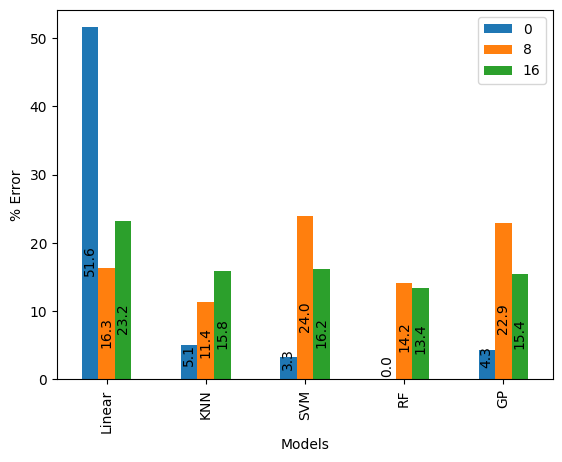

In [13]:
savedir   = f"../results/Noisy_Training_Dataset/data_property_{data_propery}_normalizer_type_{normalizer_type}_use_combat_{use_combat}_outlier_remove_{remove_outlier}_vwidth_{vwidth}{'_root_min_' if root_min else ''}{'_alpha' if add_alpha else ''}"
adj_score = False

os.makedirs(savedir, exist_ok=True)

visualization_testing_dataset(r2_score_val,  f'{savedir}/r2_score_val.png',   model_name_conversion, only_one_multivariate=False, adj_score=adj_score, legends=True)
visualization_testing_dataset(per_diff_val, f'{savedir}/per_error_val.png', model_name_conversion, only_one_multivariate=False, r2_score=False, adj_score=False, legends=True)

visualization_testing_dataset(r2_score_test,  f'{savedir}/r2_score_test.png',   model_name_conversion, only_one_multivariate=False, adj_score=adj_score, legends=True)
visualization_testing_dataset(per_diff_test, f'{savedir}/per_error_test.png', model_name_conversion, only_one_multivariate=False, r2_score=False, adj_score=False, legends=True)

visualization_class_stratified(per_diff_class_stratified_test, f'{savedir}/per_error_class_stratified.png')

## Outlier plot with box plot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
feature = 'PH'

# Find outliers 
for i in all_combined_data['y'].unique():
    Q1  = np.percentile(all_combined_data[all_combined_data['y']==i][feature], q=25)
    Q3  = np.percentile(all_combined_data[all_combined_data['y']==i][feature], q=75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    above_upper_bound = all_combined_data[[feature, 'file']][(all_combined_data[feature]>upper_bound) & (all_combined_data['y']==i)]
    above_lower_bound = all_combined_data[[feature, 'file']][(all_combined_data[feature]<lower_bound) & (all_combined_data['y']==i)]

    print(f"Con:{i}", "Above_upper_bound:", above_upper_bound['file'].values, " | ","Lower_bound",  above_lower_bound['file'].values)

plt.figure(figsize=(7,4))
sns.boxplot(all_combined_data, x='y', y=feature)
plt.show()


## Inference

In [ ]:
model_r2  = select_model('GP')
model_r2.fit(X_train[models_features_r2[model_name]], y_train)

In [ ]:
filename  = '2024_02_22_cbz00_01'
test_data = ML2_test[ML2_test['file'].apply(lambda x: True if filename in x else False)]
test_data.drop(columns='file', inplace=True)
columns   = test_data.columns
test_data = pd.DataFrame(ML2_scalar.transform(test_data), columns=columns)

test_data.rename(columns={"PH": 'univariate, max(S)', 'signal_std':'univariate, std(S)', 'signal_mean':'univariate, mean(S)', 'peak area':'univariate, area(S)', \
                        'dS_dV_area':'univariate, area(dS/dV)', 'dS_dV_max_peak':'univariate, max(dS/dV)', 'dS_dV_min_peak':'univariate, min(dS/dV)',\
                    'dS_dV_peak_diff':'univariate, max(dS/dV) - min(dS/dV)', \
                    'peak V':'univariate, V_max(S)', 'dS_dV_max_V':'univariate, V_max(dS/dV)', 'dS_dV_min_V':'univariate, V_min(dS/dV)',\
        }, inplace = True)

test_data.shape
model_r2.predict(test_data[models_features_r2[model_name]])

In [ ]:
a=39.2
b=13.7
c=15.2
print(a*48/144+b*48/144+c*49/144)